# Equations of Motion for a Rigid Body


In [2]:
:dep ndarray = { version = "0.16.1" }
:dep plotly = { version = "0.10.0" }
:dep nalgebra = { version = "0.33.1" }
extern crate ndarray;
extern crate plotly;
extern crate nalgebra;

use ndarray::{Array, Array2};
use nalgebra::{SMatrix, SVector};
use plotly::common::Mode;
use plotly::layout::{Layout};
use plotly::{Plot, Scatter};

In [375]:
#[derive(Debug)]
struct RigidBody {
    mass: f64,
    I: SMatrix::<f64, 3, 3>,
    I_inv: SMatrix::<f64, 3, 3>,
    
    // Define the state vector
    // 0 u
    // 1 v
    // 2 w
    // 3 p
    // 4 q
    // 5 r
    // 6 q0
    // 7 q1
    // 8 q2
    // 9 q3
    // 10 pn
    // 11 pe
    // 12 pd
    x: SVector::<f64, 16>,
}

impl RigidBody {
    fn new(I: SMatrix::<f64, 3, 3>, mass: f64, initial_state: SVector::<f64, 16>) -> Self {

        let I_inv = I.try_inverse().unwrap();
        
        Self {
            mass,
            I,
            I_inv,
            x: initial_state,
        }
    }

    fn normalize_quaternion(&mut self) {
        let mut q = SVector::<f64, 4>::new(self.x[6], self.x[7], self.x[8], self.x[9]);
        q.normalize();

        self.x[6] = q[0];
        self.x[7] = q[1];
        self.x[8] = q[2];
        self.x[9] = q[3];
    }

    fn quaternion_to_euler(&mut self) {
        let angles = SVector::<f64, 3>::zeros();
        let (q0, q1, q2, q3) = (self.x[6], self.x[7], self.x[8], self.x[9]);

        // Roll (phi)
        self.x[13] = (2.0 * (q0 * q1 + q2 * q3)).atan2(1.0 - 2.0 * (q1.powi(2) + q2.powi(2)));
    
        // Pitch (theta)
        self.x[14] = 2.0 * ((1.0 + 2.0 * (q0 * q2 - q1 * q3)).sqrt()).atan2((1.0 - 2.0 * (q0 * q2 - q1 * q3)).sqrt()) - std::f64::consts::PI * 0.5;
    
        // Yaw (psi)
        self.x[15] = (2.0 * (q0 * q3 + q1 * q2)).atan2(1.0 - 2.0 * (q2.powi(2) + q3.powi(2)));

    }

    fn calculate_state_derivative(&self, x: &SVector::<f64, 16>) -> SVector::<f64, 16> {
        //   0  1  2  3  4  5   6   7   8   9  10  11  12
        let (u, v, w, p, q, r, q0, q1, q2, q3, pn, pe, pd) = (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12]);
        
        let Mx = 0.0;
        let My = 0.0;
        let Mz = 0.0;
        let M = SVector::<f64, 3>::new(Mx, My, Mz);
        

        // Construct the rotation matrix from quaternion
        let R11 = q0.powi(2) + q1.powi(2) - q2.powi(2) - q3.powi(2);
        let R22 = q0.powi(2) - q1.powi(2) + q2.powi(2) - q3.powi(2);
        let R33 = q0.powi(2) - q1.powi(2) - q2.powi(2) + q3.powi(2);
        let R12 = 2.0 * (q1 * q2 - q0 * q3);
        let R21 = 2.0 * (q1 * q2 + q0 * q3);
        let R13 = 2.0 * (q1 * q3 + q0 * q2);
        let R31 = 2.0 * (q1 * q3 - q0 * q2);
        let R23 = 2.0 * (q2 * q3 - q0 * q1);
        let R32 = 2.0 * (q2 * q3 + q0 * q1);
        let R = SMatrix::<f64, 3, 3>::new(
            R11, R12, R13,
            R21, R22, R23,
            R31, R32, R33
        );
        let RT = R.transpose();
        
        // Velocity in body frame
        let Vb = SVector::<f64, 3>::new(u, v, w);
        let Vned = RT * Vb;

        let Fdamp_ned = Vned * -5.0;
        let Fgravity_ned = SVector::<f64, 3>::new(0.0, 0.0, 9.80665 * self.mass);

        // Create a spring, which only works when length is > 1. origin of spring at 0,0,0
        let min_length = 2.0;
        let r_spring = SVector::<f64, 3>::new(pn, pe, pd);
        let r_spring_norm = r_spring.normalize();
        let mut Kspring = 800.0;
        if r_spring.norm() <= min_length {
            Kspring = 0.0;
        }
        let Fspring = -Kspring * (r_spring - min_length * r_spring_norm);
        
        let Fned = Fgravity_ned + Fdamp_ned + Fspring;


        let F = R * Fned;
        
        // I'll try to do the coriolis stuff here
        let omega = SVector::<f64, 3>::new(p, q, r);
        let part1 = self.I * omega;
        let coriolis = omega.cross(&part1);
        
        let omega_dot = self.I_inv * (M - coriolis);

        let mut x_dot = SVector::<f64, 16>::zeros();
        x_dot[0] = (F[0] / self.mass) + w * q - v * r;
        x_dot[1] = (F[1] / self.mass) + u * r - w * p;
        x_dot[2] = (F[2] / self.mass) + v * p - u * q;
        x_dot[3] = omega_dot[0];
        x_dot[4] = omega_dot[1];
        x_dot[5] = omega_dot[2];
        x_dot[6] = - 0.5 * (q1 * p + q2 * q + q3 * r); // q0
        x_dot[7] = 0.5 * (q0 * p + q2 * r - q3 * q);   // q1
        x_dot[8] = 0.5 * (q0 * q + q3 * p - q1 * r);   // q2
        x_dot[9] = 0.5 * (q0 * r + q1 * q - q2 * p);   // q3

        x_dot[10] = Vned[0];
        x_dot[11] = Vned[1];
        x_dot[12] = Vned[2];
        
        x_dot
    }

    fn propagate_state(&self, dt: f64) -> SVector::<f64, 16> {
        // Runge Kutta

        let x = self.x.clone();
        let k1 = self.calculate_state_derivative(&x);
        
        let x1 = x + (0.5 * dt) * k1;
        let k2 = self.calculate_state_derivative(&x1);
        
        let x2 = x + (0.5 * dt) * k2;
        let k3 = self.calculate_state_derivative(&x2);
        
        let x3 = x + dt * k3;
        let k4 = self.calculate_state_derivative(&x3);
        
        let x4 = x + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4);

        x4
        
    }

    fn run(&mut self, steps: usize, dt: f64) -> (ndarray::Array1<f64>, Array2<f64>) {
        let mut time_series: ndarray::Array1<f64> = ndarray::Array1::<f64>::zeros(steps);
        let mut output_series: Array2<f64> = Array2::<f64>::zeros((steps, 16));

        let mut t = 0.0;
        for i in 0..steps {
            time_series[i] = t;
            let x_slice = self.x.as_slice();
            let x_view = ndarray::Array1::from(x_slice.to_vec());
            output_series.slice_mut(ndarray::s![i, 0..]).assign(&x_view);
            
            self.x = self.propagate_state(dt);
            self.normalize_quaternion();
            self.quaternion_to_euler();
            t += dt;

        }

        (time_series, output_series)
    }
}

In [376]:
let mass = 10.0;  // kg
let Ixx = 0.0167; // kg m^2
let Iyy = 0.0833; // kg m^2
let Izz = 0.125;  // kg m^2
let Ixy = 0.0;
let Ixz = 0.0;
let Iyz = 0.0;

let I = SMatrix::<f64, 3, 3>::new(
    Ixx, -Ixy, -Ixz,
    -Ixy, Iyy, -Iyz,
    -Ixz, -Iyz, Izz
);

let I_inv = I.try_inverse().unwrap();

In [377]:
let mut initial_state = SVector::<f64, 16>::zeros();
// quaternion
initial_state[6] = 1.0; // q0
initial_state[11] = 0.3; // pe
initial_state[5] = 90.0 * (std::f64::consts::PI / 180.0);
let mut body = RigidBody::new(I, mass, initial_state);
let (time, output) = body.run(5001, 0.001);
let time: Vec<f64> = time.to_vec();
let u: Vec<f64> = output.column(0).to_vec();
let v: Vec<f64> = output.column(1).to_vec();
let w: Vec<f64> = output.column(2).to_vec();
let p: Vec<f64> = output.column(3).to_vec();
let q: Vec<f64> = output.column(4).to_vec();
let r: Vec<f64> = output.column(5).to_vec();
let q0: Vec<f64> = output.column(6).to_vec();
let q1: Vec<f64> = output.column(7).to_vec();
let q2: Vec<f64> = output.column(8).to_vec();
let q3: Vec<f64> = output.column(9).to_vec();
let pn: Vec<f64> = output.column(10).to_vec();
let pe: Vec<f64> = output.column(11).to_vec();
let pd: Vec<f64> = output.column(12).to_vec();
let roll: Vec<f64> = output.column(13).to_vec().iter().map(|x| x * 180.0 / std::f64::consts::PI).collect();
let pitch: Vec<f64> = output.column(14).to_vec().iter().map(|x| x * 180.0 / std::f64::consts::PI).collect();
let yaw: Vec<f64> = output.column(15).to_vec().iter().map(|x| x * 180.0 / std::f64::consts::PI).collect();


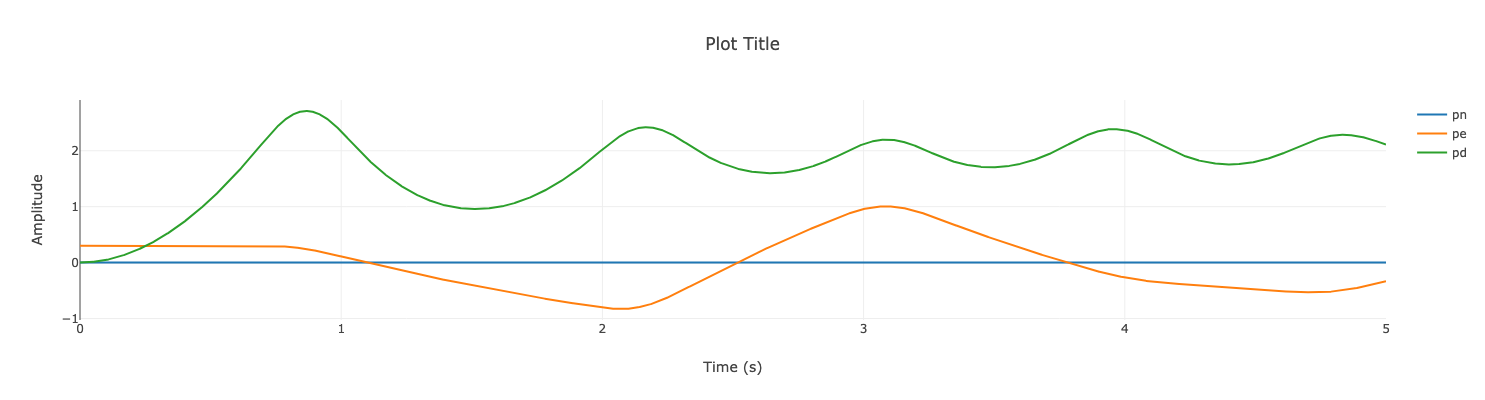

In [378]:
use plotly::*;
// Plot position vs. time
let mut plot = Plot::new();

// let trace = Scatter::new(time.clone(), roll.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("roll");
// plot.add_trace(trace);
// let trace = Scatter::new(time.clone(), pitch.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("pitch");
// plot.add_trace(trace);
// let trace = Scatter::new(time.clone(), yaw.clone())
//     .mode(plotly::common::Mode::Lines)
//     .name("yaw");
// plot.add_trace(trace);
let trace = Scatter::new(time.clone(), pn.clone())
    .mode(plotly::common::Mode::Lines)
    .name("pn");
plot.add_trace(trace);
let trace = Scatter::new(time.clone(), pe.clone())
    .mode(plotly::common::Mode::Lines)
    .name("pe");
plot.add_trace(trace);
let trace = Scatter::new(time.clone(), pd.clone())
    .mode(plotly::common::Mode::Lines)
    .name("pd");
plot.add_trace(trace);

// Set layout properties
let layout = Layout::new()
    .title("Plot Title")
    .x_axis(plotly::layout::Axis::new().title("Time (s)"))
    .y_axis(plotly::layout::Axis::new().title("Amplitude"))
    .height(400)
    .width(800);

plot.set_layout(layout);
plot.lab_display();